In [43]:
#Imports
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import glob

In [44]:
#Setting the directory for the data
data_dir = r"C:\\Users\omar0\Documents\Ben and Omar Model\Ben and Omar Model\starwars\train"

# Getting everything within directories
image_count = len(list(glob.glob(os.path.join(data_dir, '*/**.jpg'))))
print(image_count)

jedi_count = len(list(glob.glob(os.path.join(data_dir, "jedi/*"))))
sith_count = len(list(glob.glob(os.path.join(data_dir, "sith/*"))))

print(jedi_count)
print(sith_count)

#Load data using keras and create dataset
batch_size = 32
img_height = 360
img_width = 360


# Keras Training

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# Keras Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


# Things
class_names = train_ds.class_names
print(class_names)

116
54
62
Found 116 files belonging to 2 classes.
Using 93 files for training.
Found 116 files belonging to 2 classes.
Using 23 files for validation.
['jedi', 'sith']


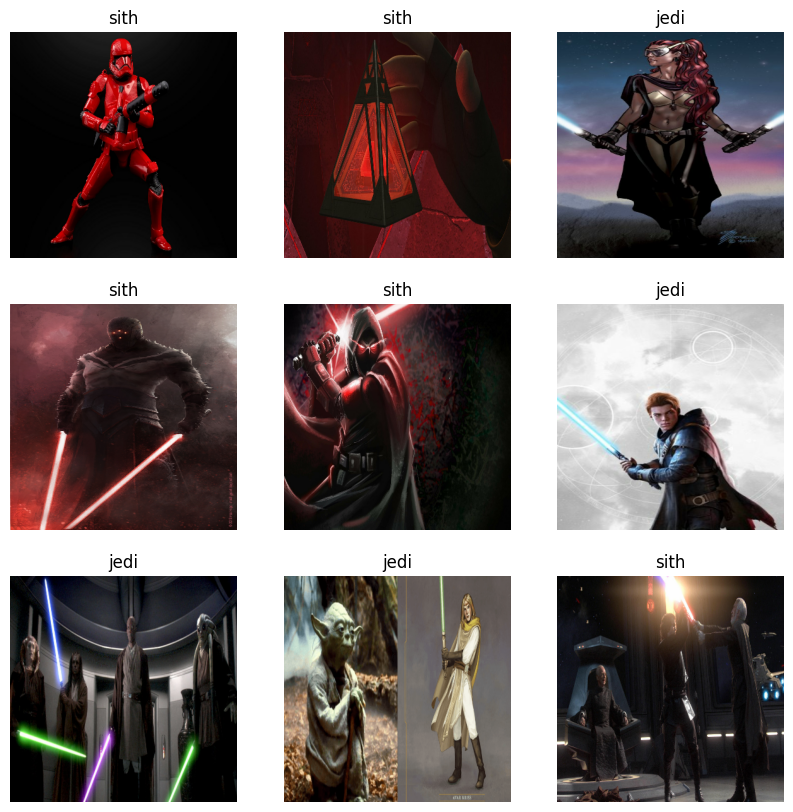

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [46]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [47]:
# Standardization
normalization_layer = tf.keras.layers.Rescaling(1./255)


# Normalizing the dataset map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# Buffered Prefetching (wud tf)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Gaming time

num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


# Optimizing the model with adam
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
# Make model

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

0.0 1.0
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 904ms/step - accuracy: 0.5914 - loss: 1.2602 - val_accuracy: 0.2609 - val_loss: 2.7984
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 705ms/step - accuracy: 0.4194 - loss: 1.3292 - val_accuracy: 0.7391 - val_loss: 0.6005
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 822ms/step - accuracy: 0.5806 - loss: 0.6371 - val_accuracy: 0.3913 - val_loss: 0.7169
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 858ms/step - accuracy: 0.7097 - loss: 0.5325 - val_accuracy: 0.4783 - val_loss: 0.7493
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 755ms/step - accuracy: 0.7634 - loss: 0.4778 - val_accuracy: 0.6957 - val_loss: 0.5482
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 736ms/step - accuracy: 0.8710 - loss: 0.3373 - val_accuracy: 0.5652 - val_loss: 0.6628
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 727ms/step - accuracy: 0.8817 - loss: 0.2986 - val_accuracy: 0.6522 - val_loss: 0.5892
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 757ms/step - accuracy: 0.9247 - loss: 0.2020 - val_accuracy: 0.6957 - v

In [51]:
# Predict
test_dir = r"C:\\Users\omar0\Documents\Ben and Omar Model\Ben and Omar Model\starwars\test\FINN.jpg"
img = tf.keras.utils.load_img(
    test_dir, target_size=(360, 360)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
This image most likely belongs to jedi with a 61.09 percent confidence.
